In [355]:
import argparse
import pandas as pd
import numpy as np
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, max_error
from matplotlib import pyplot as plt


class SimpleDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


# Define the neural network model
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.layers(x)

In [356]:
def evaluate_kfold(args):
    device = torch.device(
        "cuda" if torch.cuda.is_available() and args['cuda'] else "mps" if torch.backends.mps.is_available()
                                                                        and args['cuda'] else "cpu")
    # For fold results
    results = {}

    # Generate some random data
    torch.manual_seed(args['seed'])  # For reproducibility

    # Prepare dataset and split in train and test (train for cross validation)
    df = pd.read_csv('../models/pv1_eval.csv')

    x_test = df.drop(['temperature'], axis=1)
    y_test = df['temperature']

    # Standardizing data
    scaler = joblib.load('../models/weights/minmax_scaler.pth')    
    x_test = scaler.transform(x_test.values)

    # Tensor format of X and y
    x_test = torch.tensor(x_test, dtype=torch.float32, device=pdevice)
    y_test = torch.tensor(y_test.values, dtype=torch.float32, device=device).reshape(-1, 1)

    test_dataset = SimpleDataset(x_test, y_test)

    test_subsampler = torch.utils.data.SubsetRandomSampler([0, len(test_dataset)])

    # Define data loaders for training and testing data in this fold
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

    # Create an instance of the model
    model = RegressionModel(args['input_size'], args['hidden_size'], args['output_size']).to(device)
    
    results_dict = {}
    
    for fold in range(args['k_folds']):
        model.load_state_dict(torch.load("../models/weights/model_state.pth".format(fold)))

        # Evaluation for this fold
        with torch.no_grad():
            # Iterate over the test data and generate predictions
            for i, data in enumerate(testloader, 0):
                # Get inputs
                inputs, targets = data
                # Generate outputs
                outputs = model(inputs)
                # Compute loss
                mse = mean_squared_error(targets, outputs)
                max_er = max_error(targets, outputs)
                mape = mean_absolute_percentage_error(targets, outputs) * 100
                r2 = r2_score(targets, outputs)

            # Print metrics
            print('MSE for fold %d: %f' % (fold, mse))
            print('MaAE for fold %d: %f' % (fold, max_er))
            print('MAPE for fold %d: %f %%' % (fold, mape))
            print('R2_score for fold %d: %f' % (fold, r2))
            print('--------------------------------')
            results[fold] = {'MSE': mse,
                             'MaAE': max_er,
                             'MAPE': mape,
                             'R2_SCORE': r2
                             }

    print(f'RESULTS OF MODELS GET BY {args["k_folds"]} FOLDS')
    print('--------------------------------')
    for metric in ['MSE', 'MaAE', 'MAPE', 'R2_SCORE']:
        print('Metric {}:'.format(metric))
        sum = 0.0
        for key, value in results.items():
            print(f'Fold {key}: {value[metric]}')
            sum += value[metric]
        print(f'Average: {sum / len(results.items())}')
        print('--------------------------------')

    return outputs, targets

In [434]:
def evaluate(args):
    device = torch.device(
        "cuda" if torch.cuda.is_available() and args['cuda'] else "mps" if torch.backends.mps.is_available()
                                                                        and args['cuda'] else "cpu")
    # For fold results
    results = {}

    # Generate some random data
    torch.manual_seed(args['seed'])  # For reproducibility

    # Prepare dataset and split in train and test (train for cross validation)
    df = pd.read_csv('../models/pv1_eval.csv')
    df['lag_1'] = df['temperature'].shift(1)
    df['lag_2'] = df['lag_1'].shift(1)
    df['lag_3'] = df['lag_2'].shift(1)
    df['lag_4'] = df['lag_3'].shift(1)
    df['lag_5'] = df['lag_4'].shift(1)
    df['rolling_mean'] = df[[col for col in df.columns if 'lag' in col]].mean(axis=1)
    df = df.dropna().reset_index()
    
    df_x_test = df.drop(['temperature', 'voltage', 'temp-1', 'index'], axis=1)
    df_y_test = df['temperature']
    
    df_x_test = df_x_test[['current', 't_amb', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'rolling_mean', 'heat']]
    
    # Create an instance of the model
    model = RegressionModel(args['input_size'], args['hidden_size'], args['output_size']).to(device)
    model.load_state_dict(torch.load("../models/weights/model_complete_4.pth"))
    
    # Standardizing data
    scaler = joblib.load('../models/weights/complete_scaler_4.pth')   
    
    outputs = []
    targets = []
    
    for i in range(len(df)):
        #print(df_x_test.iloc[i].values)
        
        x_test = scaler.transform(df_x_test.iloc[i].values.reshape(1, -1))
        y_test = df_y_test[i]
                
        # Tensor format of X and y
        x_test = torch.tensor(x_test, dtype=torch.float32, device=device)
        
        #y_test = torch.tensor(y_test, dtype=torch.float32, device=device).reshape(-1, 1)

        # test_dataset = SimpleDataset(x_test, y_test)

        # test_subsampler = torch.utils.data.SubsetRandomSampler([0, len(test_dataset)])

        # Define data loaders for training and testing data in this fold
        # testloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

        results_dict = {}
    
        # Evaluation for this fold
        with torch.no_grad():
            # Iterate over the test data and generate predictions
            #for i, data in enumerate(testloader, 0):
                # Get inputs
             #   inputs, target = data
                # Generate outputs
            output = model(x_test).squeeze().tolist()      
            
            #print(output)
            
            #if i > 2:
            #    break
                  
            targets.append(y_test.squeeze().tolist())
            outputs.append(output)
    
    # Compute loss
    mse = mean_squared_error(targets, outputs)
    max_er = max_error(targets, outputs)
    mape = mean_absolute_percentage_error(targets, outputs) * 100
    r2 = r2_score(targets, outputs)
    
    results = {'MSE': mse,
               'MaAE': max_er,
               'MAPE': mape,
               'R2_SCORE': r2
              }

    print(f'RESULTS OF MODELS')
    print('--------------------------------')
    for metric in ['MSE', 'MaAE', 'MAPE', 'R2_SCORE']:
        print('Metric {}: {}'.format(metric, results[metric]))
        print('--------------------------------')

    return outputs, targets

In [435]:
args = {
    'cuda': False,
    'input_size': 9,
    'hidden_size': 16,
    'output_size': 1,
    'seed': 42,
    'k_folds': 1
}

In [436]:
outputs, targets = evaluate(args)

RESULTS OF MODELS
--------------------------------
Metric MSE: 0.002059741771587571
--------------------------------
Metric MaAE: 0.20851933593752392
--------------------------------
Metric MAPE: 0.012209948733246599
--------------------------------
Metric R2_SCORE: 0.9913475889407763
--------------------------------


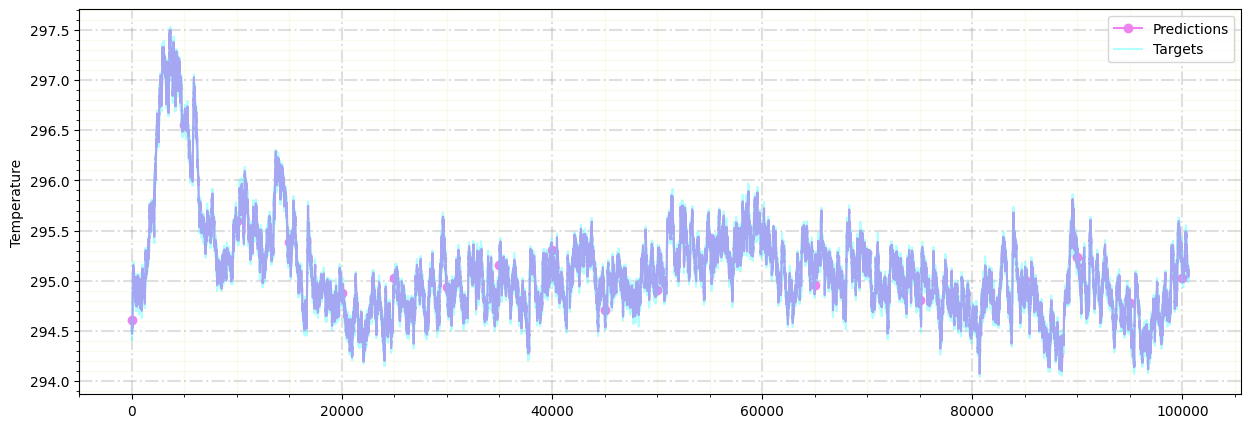

In [437]:
save_fig = False

colors = ['violet', 'cyan', 'purple', 'magenta']

plt.figure(figsize=(15,5))

# Command for the grid
plt.grid(visible=True, which='major', color='gray', alpha=0.25, linestyle='dashdot', lw=1.5)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)

plt.plot(outputs, color=colors[0], label='Predictions', marker='o', markevery=5000)
plt.plot(targets, color=colors[1], label='Targets', alpha=0.3)

plt.ylabel('Temperature')

plt.legend()

if save_fig:
    plt.savefig(fig_name, format='svg', transparent=True, dpi=200)

plt.show()